Set Parameters

In [1]:
similarity_cutoff = 0.05 
#time_slice = slice("2021-09-12 14:00:00", "2021-09-12 14:00:00")
time_slice = slice("2021-09-12 14:00:00", "2021-09-12 22:00:00")

Import files 

In [2]:
import xarray as xr 

In [3]:
compound = xr.open_dataset('compound_nicholas.nc', chunks={'time': 'auto'})
surge = xr.open_dataset('surge_nicholas.nc', chunks={'time': 'auto'})
rivers = xr.open_dataset('rivers_nicholas.nc', chunks={'time':'auto'})

In [4]:
x = compound['x']; y = compound['y'] 
ele_X_nodes = compound['element']-1 #extract element to global node map (connectivity map)

compound_zeta = compound['zeta'].sel(time=time_slice)
surge_zeta = surge['zeta'].sel(time=time_slice)
rivers_zeta = rivers['zeta'].sel(time=time_slice)

Calculate Differences, Compute Divergence Metric

In [5]:
from numba import vectorize, float64
import numpy as np 

#Need to formalize this logic. 
@vectorize([float64(float64,float64)])
def bathymetric_rel_diff(a: float, b: float) -> float:
    """
    Takes a relative-to-minuend difference between two bathymetries, making optimizations where dry cells are 
    encountered. Intended to be combined with Numba's vectorize and Xarray's apply_ufunc.                                                                                                                        

    Parameters
    ----------
    a : np.ndarray
        Minuend. 
    b : np.ndarray
        Subtrahend. 
    
    Returns
    -------
    difference : np.float
    
    Examples
    --------
    >>> a = [1 nan nan]
    >>> b = [1 1 nan]
    >>> xr.apply_ufunc(fast_bathymetric_diff_atomic,a,b)
    [0 -1 0]
    
    """    
    #Case where both are dry 
    if np.isnan(a) and np.isnan(b): 
        return 0
    
    #Double check this behavior. 
    if np.isnan(a): 
        return 999 
    if np.isnan(b): 
        b = 0 
    
    return abs((a-b)/a) 

#currently, this does not set any nan's, but maybe this is okay with holoviews. 
compound_surge_difference = xr.apply_ufunc(bathymetric_rel_diff, compound_zeta, surge_zeta, dask ="parallelized")
river_surge_difference = xr.apply_ufunc(bathymetric_rel_diff, compound_zeta, rivers_zeta, dask='parallelized')

compound_surge_difference_max = compound_surge_difference.max(dim="time")
river_surge_difference_max = river_surge_difference.max(dim="time")

divergence_of_surge_and_rivers = np.minimum(compound_surge_difference_max,river_surge_difference_max) 

Mesh time series data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
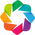

/opt/miniconda3/envs/transition-zone/lib/python3.11/site-packages/holoviews/core/util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)


In [6]:
import geoviews as gv 
import holoviews as hv 
hv.extension("bokeh")
from holoviews import opts
from holoviews.operation.datashader import datashade,rasterize
import datashader as ds


datashade.precompute=True 
size = dict(width=800, height=600)
opts.defaults(
    opts.Image(**size), opts.RGB(**size), opts.VectorField(**size))

times = compound['time'].sel(time=time_slice).to_numpy() 

points = gv.operation.project_points(gv.Points((x,y)))

tris = ele_X_nodes.to_numpy()

def mesh_at_time(timestamp): 
    depth_points = points.add_dimension('zeta', 0, compound_surge_difference.sel(time=timestamp), vdim = True)
    return gv.TriMesh((tris, depth_points))

meshes_dict = {t:mesh_at_time(t) for t in times}
meshes_HoloMap = hv.HoloMap(meshes_dict, kdims="times")

tiles = gv.tile_sources.OSM 
#figure out how to set the range properly here (using inf not using 3)
meshes_raster = rasterize(meshes_HoloMap, interpolation='linear', aggregator=ds.mean('zeta')).opts(colorbar=True, clim=(0.01, 0.1), color_levels=9, clipping_colors={'min': 'transparent', 'max': 'green', 'NaN': 'transparent'})
plot = tiles * meshes_raster 


In [7]:
hv.output(plot, holomap='scrubber', fps=4)

BokehModel(combine_events=True, render_bundle={'docs_json': {'502714d0-6aa7-4e5b-b7a1-d7be49610119': {'version…

Mesh and plot divergence metric 

In [8]:
depth_points = points.add_dimension('zeta', 0, divergence_of_surge_and_rivers, vdim = True)
maxmesh = gv.TriMesh((tris, depth_points))
maxmesh_raster = rasterize(maxmesh, interpolation='linear', aggregator=ds.max('zeta')).opts(colorbar=True, 
                                                                                            clim=(0.02, 0.5), 
                                                                                            color_levels=9, 
                                                                                            clipping_colors={'min': 'transparent', 'max': 'green', 'NaN': 'transparent'})
plot = tiles * maxmesh_raster 
hv.output(plot)

BokehModel(combine_events=True, render_bundle={'docs_json': {'bb36641c-9bc6-4a1b-8645-9abfa66490df': {'version…

Task exception was never retrieved
future: <Task finished name='Task-7' coro=<Callback.process_on_change() done, defined at /opt/miniconda3/envs/transition-zone/lib/python3.11/site-packages/holoviews/plotting/bokeh/callbacks.py:328> exception=UnsetValueError("figure(id='p1132', ...).inner_height doesn't have a value set")>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/transition-zone/lib/python3.11/site-packages/holoviews/plotting/bokeh/callbacks.py", line 347, in process_on_change
    msg[attr] = self.resolve_attr_spec(path, cb_obj)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/transition-zone/lib/python3.11/site-packages/holoviews/plotting/bokeh/callbacks.py", line 254, in resolve_attr_spec
    resolved = getattr(resolved, p, None)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/transition-zone/lib/python3.11/site-packages/bokeh/core/property/descriptors.py", line 283, in __get__
    raise UnsetValueError(f"

Now do the actual contouring

/tmp/ipykernel_17064/2502773124.py:7: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = contours.collections[0].get_paths()


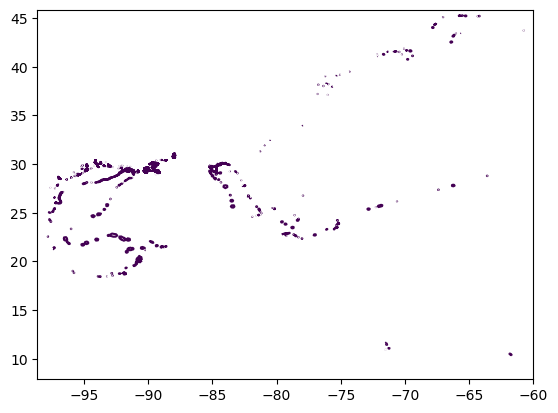

In [14]:
from matplotlib.tri import Triangulation
from matplotlib.pyplot import tricontour
from shapely.geometry import Polygon, LineString 
triang = Triangulation(x,y,tris)
contours = tricontour(triang,divergence_of_surge_and_rivers, levels = [0.5], extend = 'max')

paths = contours.collections[0].get_paths()
contour_LineStrings = [LineString(path.vertices) for path in paths if len(path.vertices)>2]